# CNN-based Brain Tumour Detector
## Import packages
Please make sure you have all the required packages installed.

In [2]:
import numpy as np
from tqdm import tqdm
import os
import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import shutil
import tensorflow

from keras import layers
from keras.layers import *
from keras.models import *
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
#@@
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

2024-07-10 11:39:34.237416: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-10 11:39:34.295258: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-10 11:39:35.074642: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with 

## Data preparation (this step has been done for you)

Images in the original dataset are usually in different sizes, so we need to resize and normalise them to fit the CNN model. Depending on the images you choose to use for training your model, some other preprocessing methods (cropping, zooming, etc.) may be required.


## Split your dataset into training and validation
Validation dataset would not be used to train your network, it is normally for evaluating your model performance and choosing the best set of hyperparameters. Choose the size of your training and validation set yourself.

In [3]:
#uncomment if using linux/macos
!rm -rf Train Val
!mkdir Train Val Train/Yes Train/No Val/Yes Val/No

#uncomment if using windows
# !rmdir Train Val /s /q
# !md Train Val Train\Yes Train\No Val\Yes Val\No


img_path = 'dataset_classification/'
train_list = []
val_list = []
for CLASS in os.listdir(img_path):
    if not CLASS.startswith('.'):
        all_files = os.listdir(img_path + CLASS)
        files = [item for item in all_files if "img" in item]
        random.shuffle(files)
        img_num = len(files)
        for (n, file_name) in enumerate(files):
            img = os.path.join(img_path,CLASS,file_name)
            seg = os.path.join(img_path,CLASS,file_name.split('_')[0]+'_seg.npy')
            # 80% of images will be used for training, change the number here 
            # to use different number of images for training your model.
            if n < 0.8*img_num:
                shutil.copy(img, os.path.join('Train/',CLASS,file_name))
                train_list.append(os.path.join('Train/',CLASS,file_name))
                shutil.copy(seg, os.path.join('Train/',CLASS,file_name.split('_')[0]+'_seg.npy'))
            else:
                shutil.copy(img, os.path.join('Val/',CLASS,file_name))
                val_list.append(os.path.join('Val/',CLASS,file_name))
                shutil.copy(seg, os.path.join('Val/',CLASS,file_name.split('_')[0]+'_seg.npy'))


## Plot images
Plot some sample images here.

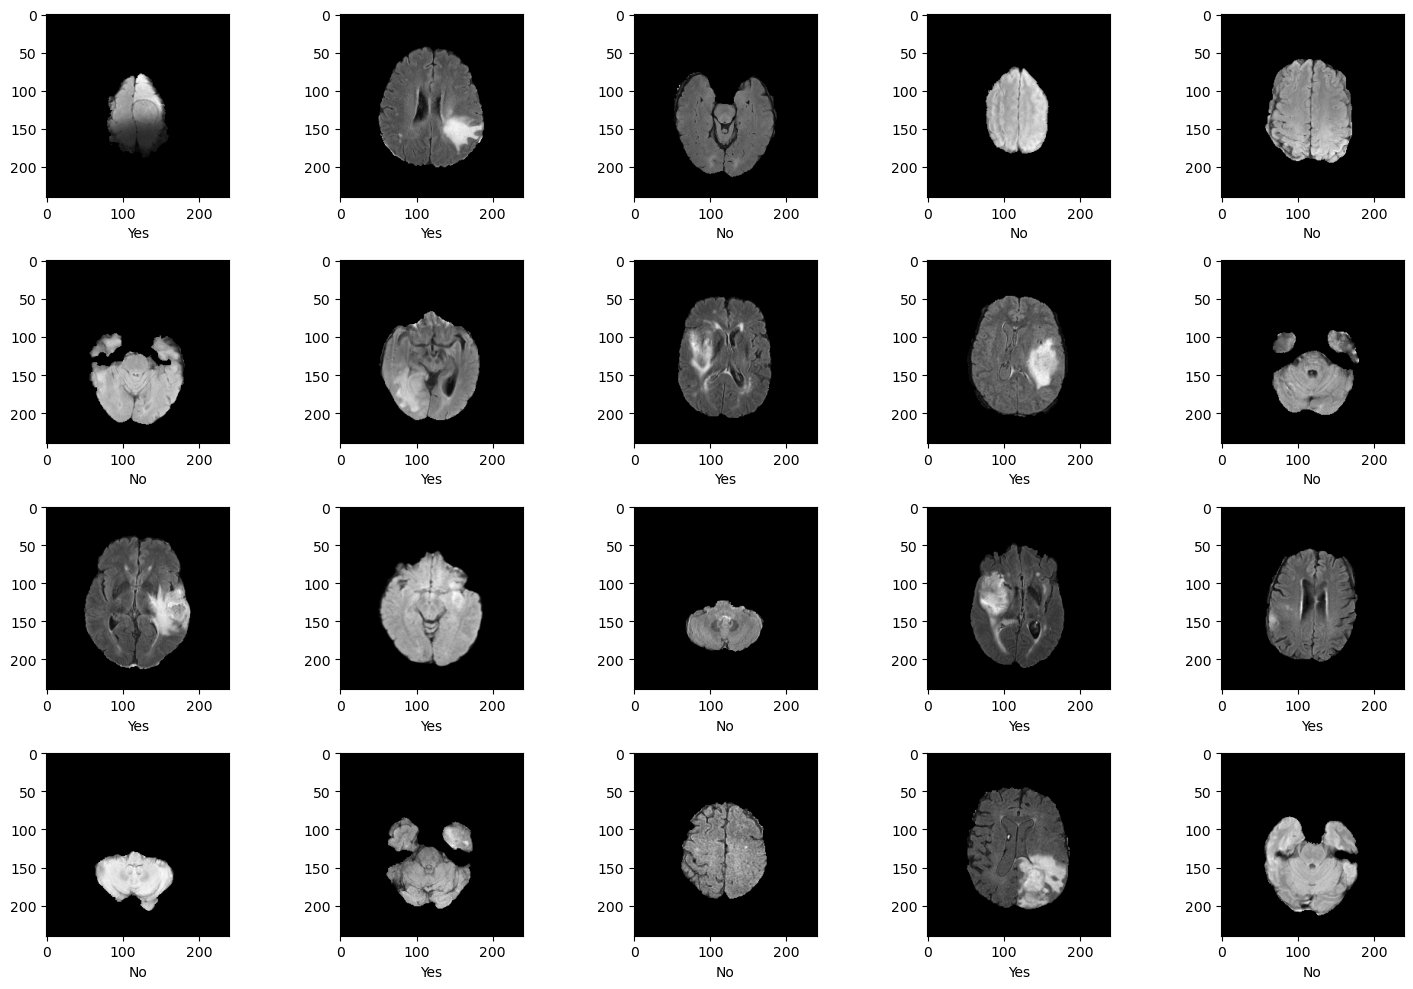

In [4]:
def plot_samples(img_path,n=20):
    files_list = []
    labels_list = []
    for path, subdirs, all_files in os.walk(img_path):
        files = [item for item in all_files if "img" in item]
        for name in files:
            files_list.append(os.path.join(path, name))
            labels_list.append(path.split('/')[1])
    imgs_lbls = list(zip(files_list, labels_list))
    random.shuffle(imgs_lbls)
    files_list, labels_list = zip(*imgs_lbls)
    j = 5
    i = int(n/j)
    plt.figure(figsize=(15,10))
    k = 1
    for file, lbl in zip(files_list[:n], labels_list[:n]):
        img = np.load(file)
        plt.subplot(i,j,k)
        plt.imshow(img[:,:,0], cmap='gray')
        plt.xlabel(lbl)
        k += 1
    plt.tight_layout()
    plt.show()
    
plot_samples(img_path)

## Train-time data augmentation
Generalizability is crucial to a deep learning model and it refers to the performance difference of a model when evaluated on the seen data (training data) versus the unseen data (testing data). Improving the generalizability of these models has always been a difficult challenge. 

<img src="files/img.jpg">


**Data Augmentation** is an effective way of improving the generalizability, because the augmented data will represent a more comprehensive set of possible data samples and minimizing the distance between the training and validation/testing sets.

There are many data augmentation methods you can choose in this projects including rotation, shifting, flipping, etc.

You are encouraged to try different augmentation method to get the best classification accuracy.

**Question**

Applying data augmentation to medical images may sometimes make the images uninterpretable to human. For instance, a heart may not look like a heart after shearing the image. Would training the model with these uninterpretable images helpful to improving the model performance? Why do you think it is helpful/not helpful?

## Get the data generator ready

You may change the batch size of your training data here. A large batch size or even a batch size that equals to the entire dataset is more likely to get your model to the convergence to the global optima of the loss function, but this is at the cost of computational efficiency and sometimes large batch size would lead to a bad model generalisation. 

There is always a trade-off between large and small batch size. Choose a reasonable batch size here to get the best model performance.

In [5]:
class DataGenerator(tensorflow.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=32, dim=(240,240), n_channels=3,
                 n_classes=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            # Add data augmentation here
            X[i,] = np.load(ID)

            # Store class
            y[i] = min(1,np.sum(np.load(ID.split('_')[0]+'_seg.npy')))

        return X, tensorflow.keras.utils.to_categorical(y, num_classes=self.n_classes)

In [6]:
train_generator = DataGenerator(train_list)
validation_generator = DataGenerator(val_list)
img_size = (240,240)

## Load the backbone model

To extract the features from the dataset, a backbone network is used here. Initially, VGG16 is used here as an example.

To achieve the best classification accuracy, you are encouraged to try different models. A list of models you can try is given at https://keras.io/api/applications/. Remember to update the **Preparing your environment** and **this** part to use a different backbone model, for instance, to use the ResNet50 as the backbone network, change 'from keras.applications.vgg16 import VGG16, preprocess_input' into 'from keras.applications.resnet_v2 import ResNet50, preprocess_input'

These models are pretrained on ImageNet dataset for classification task and you can choose to finetune the pretrained network (transfer learning: https://papers.nips.cc/paper/5347-how-transferable-are-features-in-deep-neural-networks.pdf) or train it from the scratch for the tumour detection task.

VGG16: https://arxiv.org/pdf/1409.1556

ResNet: https://arxiv.org/abs/1512.03385

DenseNet: https://arxiv.org/abs/1608.06993

**Question**

What are the advantages and disadvantages of finetuning a model for tumour detection?

In [7]:
base_model = VGG16(
    #uncomment if you want to train your network from scratch.
    weights = None,
    include_top=False, 
    input_shape=img_size+(3,)
)

2024-07-10 11:39:38.500056: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-10 11:39:38.500226: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-10 11:39:38.500296: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-10 11:39:38.500508: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-10 11:39:38.500583: I tensorflow/compiler/xla/stream_executo

## Build the model for tumour detection

A classifier is added to the backbone network here. The loss function used to train the model is binary cross entropy (details can be found at https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class and https://machinelearningmastery.com/cross-entropy-for-machine-learning/). 

The optimizer used here is ADAM (https://arxiv.org/abs/1412.6980) and you can leave it unchanged.

In [1]:
num_classes = 2

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='sigmoid'))

# uncomment here if you want to finetune the top layer(classifier) of a pretrained network only. 
# model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

NameError: name 'Sequential' is not defined

## Train the model
The early stopping would stop the training process when a pre-defined metric stops improving. More details can be found at https://keras.io/api/callbacks/early_stopping/.

In [9]:
num_epochs = 2
earlystopping = EarlyStopping(
    monitor='accuracy', 
    mode='max',
    patience=20
)

history = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=validation_generator,
    callbacks=[earlystopping]
)

Epoch 1/2


2024-07-10 11:39:39.276403: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8902
2024-07-10 11:39:39.375145: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2024-07-10 11:39:39.376105: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2024-07-10 11:39:39.376115: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:237] Used ptxas at ptxas
2024-07-10 11:39:39.376145: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation.

 1/14 [=>............................] - ETA: 2:49 - loss: 0.6923 - accuracy: 0.7188

2024-07-10 11:39:51.650397: W tensorflow/tsl/framework/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


14/14 [==============================] - 18s 354ms/step - loss: 0.6441 - accuracy: 0.6116 - val_loss: 0.5819 - val_accuracy: 0.6875
Epoch 2/2
14/14 [==============================] - 5s 343ms/step - loss: 0.5790 - accuracy: 0.6964 - val_loss: 0.6201 - val_accuracy: 0.6979


## Plot training result##

**Question**

What causes the gap between training accuracy/loss and test accuracy/loss? How do you reduce the gap between training accuracy/loss and test accuracy/loss?

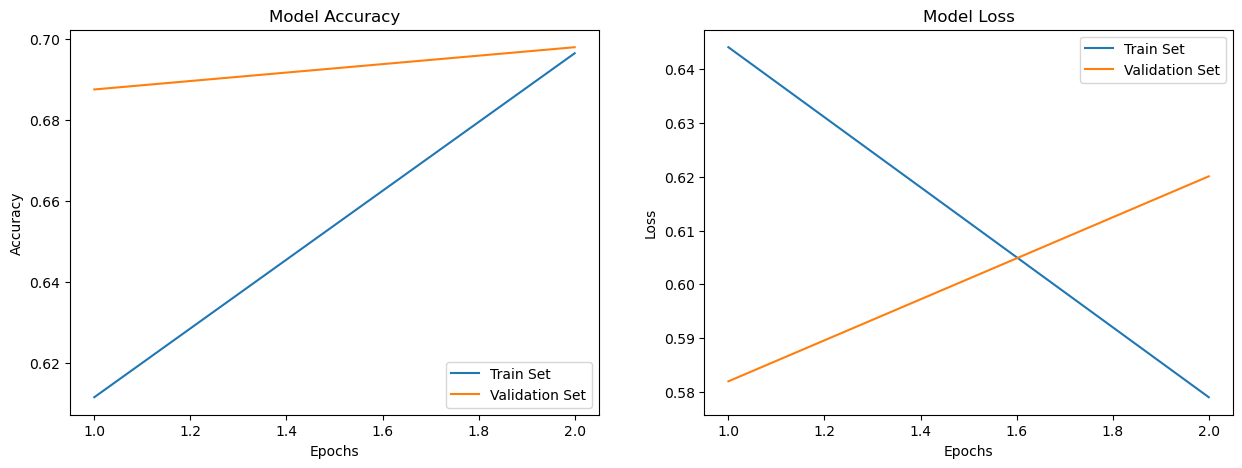

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Validation Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Validation Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.show()

## Save your trained model
If you feel your model has been trained to convergence, save it here.

In [11]:
model.save('trained_model.h5')

## Test the model
Test your trained model here.

In [12]:
test_dir = 'Val/'
#load your model here
model = load_model('trained_model.h5')
test_list = []
for CLASS in os.listdir(test_dir):
    if not CLASS.startswith('.'):
        all_files = os.listdir(test_dir + CLASS)
        files = [item for item in all_files if "img" in item]
        for file_name in files:
            test_list.append(test_dir + CLASS + '/' + file_name)
test_generator = DataGenerator(test_list, batch_size=1)

predictions = []
y_test = []
for i in range(test_generator.__len__()):
    x_test, y = test_generator.__getitem__(i)
    y_test.append(y[0][1])
    prediction = model.predict(x_test)
    predictions.append(np.int(prediction[0][1]>0.5))
accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

1/1 [==============================] - 0s 15ms/step


/tmp/ipykernel_18594/2568004405.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions.append(np.int(prediction[0][1]>0.5))


1/1 [==============================] - 0s 12ms/step
Test Accuracy = 0.71
